In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Repasemos un poco que estuvimos haciendo al final de la Clase del Martes

Para este set de datos

In [ ]:
# Nuevo set de datos (esta vez, hago dos copias)
x_ = np.random.rand(20, 1)
t_ = np.sin(2*np.pi*x_) + np.random.randn(len(x_), 1) * 0.3

# Antes que nada, voy a separar en conjunto de entrenamiento y de testeo
x_train, x_test = x_[:10], x_[10:]
t_train, t_test = t_[:10], t_[10:]

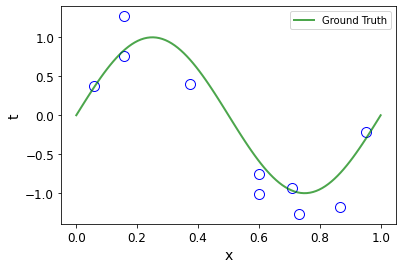

In [ ]:
# Array para plotear
xx = np.linspace(0, 1, 100).reshape([-1, 1])

def plot_data_sine(x, t, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, t, 'ob', mfc='None', ms=10)
    ax.plot(xx, np.sin(2*np.pi * xx), 'g-', lw=2, alpha=0.7, label='Ground Truth')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.legend(loc=0)
    return

plot_data_sine(x_train, t_train)

Hicimos una regresion con distintos polinomios, con ayuda de scikit-learn

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
import sklearn.preprocessing  as pp
from sklearn.linear_model import LinearRegression

# Creo el pipeline
pp_sine = Pipeline([('poly', pp.PolynomialFeatures()),#[x1,x2,x3,..,xD]->[1,x1,x2,x3,...,xD,x1^2,x2^2,..,xD^2,x1*x2,...,xD-1*xD,...,xD^M], si entro con np.array de (N,D)->(N,sum_{i=0}^M (D M)
#D = 1, x -> [1,x,x^2,...,x^M]
                     ('lr', LinearRegression(fit_intercept=False))])

# Inicializo listas
degrees = [1, 2, 3, 5, 7, 9, 11]
coeffs = []
rmse = []
rmse_test = []
preds = []
# Itero sobre los grados
for d in degrees:
    # Fijo el grado
    pp_sine.named_steps['poly'].degree = d
    
    # Fiteo (y registro los valores de los parámetros)
    pp_sine.fit(x_train, t_train)
    coeffs.append(pp_sine.named_steps['lr'].coef_)
    
    # Obtengo predicciones
    y_train = pp_sine.predict(x_train)
    y_test = pp_sine.predict(x_test)
    preds.append(pp_sine.predict(xx))

    # Calculo el RMSE    
    rmse.append(np.sqrt(mse(t_train, y_train)))
    rmse_test.append(np.sqrt(mse(t_test, y_test)))

Y observamos como cambia la performance

1 0.5138278533264234 0.704882957029713
2 0.4535727624425297 0.7881204425029278
3 0.17676743804959566 0.27300173540844813
5 0.15907779006006803 0.288512429646581
7 0.12296860144090023 5.487998867482539
9 2.6346155489113077e-08 2026.3104655775282
11 9.4182394620765e-09 1694.8054995376904


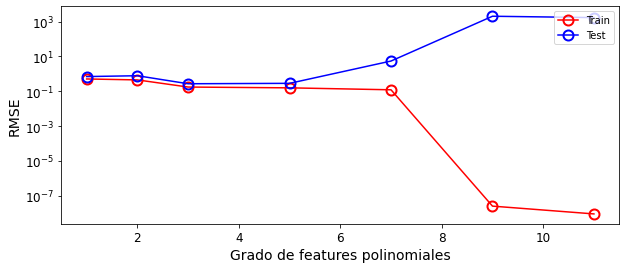

In [ ]:
# Veamos cómo evoluciona la métrica con el número de grados de libertad
plt.figure(figsize=(10,4))
plt.plot(degrees, rmse, 'o-r', mfc='None', ms=10, mew=2, label='Train')
plt.plot(degrees, rmse_test, 'o-b', mfc='None', ms=10, mew=2,label='Test')
plt.xlabel('Grado de features polinomiales')
plt.ylabel('RMSE')
plt.yscale('log')
plt.legend(loc='upper right')
for i, d in enumerate(degrees):
    print(d, rmse[i], rmse_test[i])

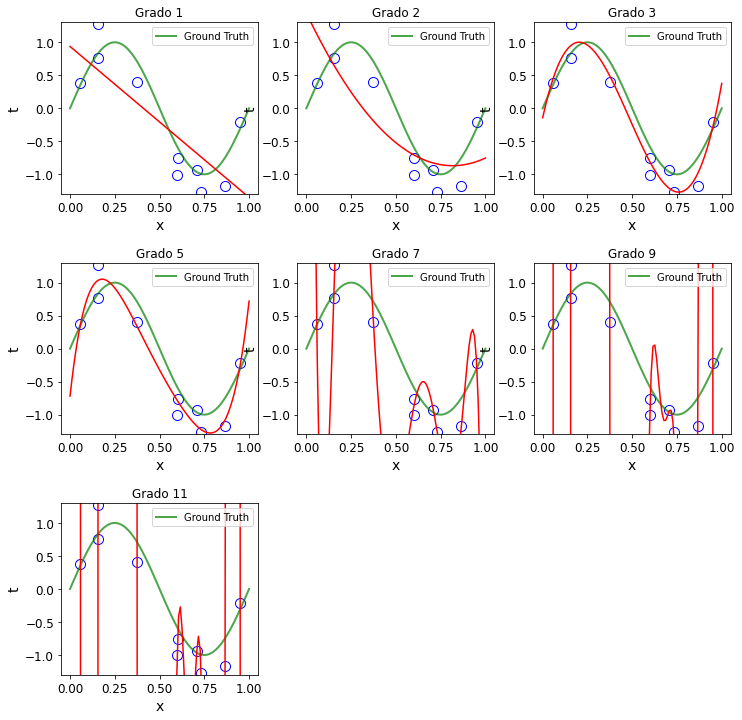

In [ ]:
ncols = 3
nrows = np.int(np.ceil(len(degrees)/ncols))

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

for i, d in enumerate(degrees):
    ax = fig.add_subplot(nrows, ncols, i+1)
    plot_data_sine(x_train, t_train, ax=ax)
    ax.plot(xx, preds[i], 'r-', label='Prediction')
    ax.set_ylim(-1.3, 1.3)
    ax.set_title('Grado {}'.format(d))

Antes de avanzar con el tema del sobre-ajuste y como evitarlo, retrocedamos un poco. Que esta haciendo scikit-learn?




# Ecuaciones Normales

## Planteo

Vamos a plantear el problema utilizando la notacion del Bishop (en particular el capitulo 3). 

Nosotros tenemos $N$ mediciones. Para cada medicion $n$, medimos un vector de features $\vec{x}_{n}$, donde la dimension de $\vec{x}$ es $D$, y un target $t_{n}$. En el ejemplo de mas arriba, $D=1$ y $N=10$.

Lo que vimos las clases pasadas es que, asumiendo un modelo lineal, podemos maximizar la verosimilitud:

$p(\textbf{t}|\textbf{X},\vec{w},\beta)=\prod_{n=1}^{N}\mathcal{N}(t_{n}|y(\vec{x}_{n},\vec{w}),\beta^{-1})$

Donde $\textbf{t}$ es un vector columna $(t_{1},...,t_{N})^{T}$ y $\textbf{X}=${$\vec{x_{1}},...,\vec{x}_{N}$} es la coleccion de mediciones.

$y(\vec{x}_{n},\vec{w})$ es la funcion que estima el valor esperado para la medicion $n$-esima a partir de $\vec{x}_{n}$ y el vector de pesos $\vec{w}$.

Para el caso mas sencillo que vimos, D=1, tomamos

$y(x,(w_{0},w{1})^{T})=w_{0}+w_{1}\cdot x$

Esto puede escribirse como:

$y(x,\vec{w})=w_{0}\cdot \phi_{0}(x) + w_{1}\phi_{1}(x)$

$y(x,\vec{w})=\vec{w}^{T}\cdot \vec{\phi}(x)$

Con $\phi_{0}(x)=1$ y $\phi_{1}(x)=x$

Que utilidad tiene esto? Ahora la vamos a ver, quedense conmigo.

Maximizar la verosimilitud era equivalente a minimizar el error en cuadrados minimos

$E_{D}(\vec{w})=\frac{1}{2}\sum_{n=1}^{N}(t_{n}-y(\vec{x}_{n},\vec{w}))^{2}$
$E_{D}(\vec{w})=\frac{1}{2}\sum_{n=1}^{N}(t_{n}-\vec{w}^{T}\cdot\vec{\phi}(\vec{x}_{n}))^{2}$

Una belleza de este algoritmo es que tiene solucion exacta. Encontremosla.

Si derivamos en funcion de $\vec{w}$ (PREGUNTENME PORQUE NO EXPLICITO LA DIMENSION DE $\vec{w}$) encontramos una ecuacion vectorial:

$\sum_{n=1}^{N}(t_{n}-\vec{w}^{T}\cdot\vec{\phi}(\vec{x}_{n}))\cdot\phi^{T}(\vec{x}_{n})=0$

Frenemos a analizar esto con sus dimensiones

$\vec{w}$ tiene dimension $(M,1)$. $\vec{w}^{T}$  tiene dimension $(1,M)$. $\vec{\phi}$ tiene dimension $(M,1)$, $\vec{\phi}^{T}$  tiene dimension $(1,M)$.

## Mini repaso de derivadas vectoriales


Es importante saber operar con matrices, y tambien derivar. 

El paso de recien fue quizas muy "truco de magia" asi que expliquemoslo. El error es un escalar. Como yo derivo en funcion de _cada componente de $\vec{w}$_ al mismo tiempo e igualo a cero, tengo un conjunto $M$ ecuaciones.

$\frac{\partial E_{D}(\vec{w})}{\partial w_{i}}=0$

Aplico la regla de la suma y de la cadena de manera que

$\frac{\partial}{\partial w_{i}}\sum_{n=1}^{N}\frac{1}{2}(t_{n}-\vec{w}^{T}\cdot\vec{\phi}(\vec{x}_{n}))^2=\sum_{n=1}^{N}\frac{1}{2}\frac{\partial u^2}{\partial u} \frac{\partial u}{\partial w_{i}}$

Con $u=t_{n}-\vec{w}^{T}\cdot\vec{\phi}(\vec{x}_{n})$. Calculando, llego a:

$ \sum_{n=1}^{N}(t_{n}-\vec{w}^{T}\cdot\vec{\phi}(\vec{x}_{n}))\phi_{i}(\vec{x}_{n}) = 0$


## Sigamos

Podemos encontrar los coeficientes $\vec{w}_{\text{ML}}$ que maximizan la verosimilitud resolviendo esa ecuacion. La solucion es:

$\vec{w}_{\text{ML}}=\left(\Phi^{T}\cdot\Phi\right)^{-1}\Phi^{T}\cdot \textbf{t}$

Donde $\Phi$ es la matriz de diseño. Que dimensiones tiene?

$\Phi$ tiene dimension datos x funciones de base $\rightarrow (N,M)$

## Tras discutir dimensiones

En efecto, $\Phi$ en este caso es una matriz de $N$x2. En general, sera de $N$x$M$, donde la $n$-esima fila seran las funciones $\phi_{j}(\vec{x}_{n})$, con $j=0,1,...,M-1$ y la m-esima columna seran las funciones $\phi_{m}(\vec{x}_{i})$ con $i=1,...,N$.

En nuestro caso, tenemos que $\phi_{O}(x)=1$, $\phi_{1}(x)=x$. Utilizemos el comando np.hstack para armar la matriz de diseño.



In [ ]:
Phi=np.hstack((np.ones(x_train.shape),x_train))
Phi

array([[1.        , 0.37454012],
       [1.        , 0.95071431],
       [1.        , 0.73199394],
       [1.        , 0.59865848],
       [1.        , 0.15601864],
       [1.        , 0.15599452],
       [1.        , 0.05808361],
       [1.        , 0.86617615],
       [1.        , 0.60111501],
       [1.        , 0.70807258]])

Veamos que los shapes son adecuados a medida que avanzamos:

In [ ]:
# Ahora calculemos el producto de phi por su transpuesta y verifiquemos que la forma es la correcta
pp1 = np.dot(Phi.T, Phi)
pp2 = Phi.T @ Phi

print('Las dos notaciones para el producto de matrices son idénticas: {}'.format(np.allclose(pp1, pp2)))

print('La dimension es: {}'.format(pp1.shape))
# y el producto entre Phi y el vector t
yy = np.dot(Phi.T, t_train)
print('La dimension es: {}'.format(yy.shape))

Las dos notaciones para el producto de matrices son idénticas: True
La dimension es: (2, 2)
La dimension es: (2, 1)


En lugar de resolver la ecuacion tal como la escribimos, podemos resolver la siguiente ecuacion de manera mas eficiente

$(\Phi^{T}\cdot\Phi)\cdot\vec{w}_{\text{ML}}=\Phi^{T}\cdot\textbf{t}$

Con ayuda del comando `np.linalg.solve`

In [ ]:
wml = np.linalg.solve(pp1, yy)
print(wml)

[[ 0.9368527 ]
 [-2.28701317]]


Y la solucion de sklearn es:



In [ ]:
print(coeffs[0])

[[ 0.9368527  -2.28701317]]


Y si ahora quiero hacer una prediccion?

Bueno, unicamente necesito hacer 

$y_{n}=\vec{w}^{T}_{\text{ML}}\cdot\phi(\vec{x}_{n})$

Si es para todo un conjunto de datos,

$\textbf{y}=\Phi\cdot\vec{w}_{\text{ML}}$

In [ ]:
y_train_manual=np.dot(Phi,wml)
print(y_train_manual.shape)
print(np.sqrt(mse(t_train, y_train_manual)))

(10, 1)
0.5138278533264234


Veamos que en efecto estamos haciendo la operacion adecuada:

In [ ]:
y_train_manual_2 = np.array([wml[i] * Phi[:, i] for i in range(Phi.shape[1])])
y_train_manual_2 = np.sum(y_train_manual_2, axis=0)
print('Hacer ambas cosas es lo mismo: {}'.format(np.allclose(y_train_manual, y_train_manual_2[:, np.newaxis])))

Hacer ambas cosas es lo mismo: True


Text(0.5, 1.0, 'Grado 1')

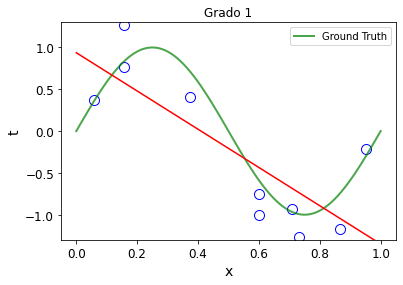

In [ ]:
Phi_preds=np.hstack((xx*0.0+1.0,xx))
preds_manual=np.dot(Phi_preds,wml)

plot_data_sine(x_train, t_train)
plt.plot(xx, preds_manual, 'r-', label='Prediction')
plt.ylim(-1.3, 1.3)
plt.title('Grado {}'.format(1))

## Mas en general

En general, podemos trabajar con $M$ funciones de base, donde por convencion $\phi_{0}(x)=1$ y las otras $M-1$ funciones son arbitrarias y fijas.

En particular, podemos recuperar los resultados para el polinomios de grado 3. 

In [ ]:
## Obtengan los coeficientes

In [ ]:
## Obtengan las predicciones y plotteen

# Validacion cruzada

## Volvamos ahora al problema del overfitting.

Como vimos, cuando aumentamos el grado del polinomio observamos que habia un sobreajuste. La pregunta es como cuantificar esto sin tener que ir al conjunto de test.

Una opcion, la primera y que vamos a reutilizar con Deep Learning, es separar el conjunto de entrenamiento en un subconjunto de verdadero entrenamiento y otro de validacion. Como convencion, tomamos el 20%.

In [ ]:
x_train_2, x_val = x_train[:9], x_train[9:]
t_train_2, t_val = t_train[:9], t_train[9:]

Y entonces entrenamos cada polinomio en train_2 y evaluamos en val

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Creo el pipeline
pp_sine = Pipeline([('poly', PolynomialFeatures()),
                     ('lr', LinearRegression(fit_intercept=False))])

# Inicializo listas
degrees = [1, 2, 3, 5, 7, 9, 11]
coeffs = []
rmse = []
rmse_val = []
preds = []
# Itero sobre los grados
for d in degrees:
    # Fijo el grado
    pp_sine.named_steps['poly'].degree = d
    
    # Fiteo (y registro los valores de los parámetros)
    pp_sine.fit(x_train_2, t_train_2)
    coeffs.append(pp_sine.named_steps['lr'].coef_)
    
    # Obtengo predicciones
    y_train_2 = pp_sine.predict(x_train_2)
    y_val = pp_sine.predict(x_val)
    preds.append(pp_sine.predict(xx))

    # Calculo el RMSE    
    rmse.append(np.sqrt(mse(t_train_2, y_train_2)))
    rmse_val.append(np.sqrt(mse(t_val, y_val)))

1 0.5341393528022618 0.29013020995769656
2 0.47656687039283774 0.1267160441272761
3 0.15068311685812424 0.3825965535135383
5 0.1377657427122554 0.34416472459780834
7 0.11672994888633657 1.7407761551729168
9 4.913221189318244e-09 26.10422857622887
11 1.8680058352756635e-09 50.22678018302229


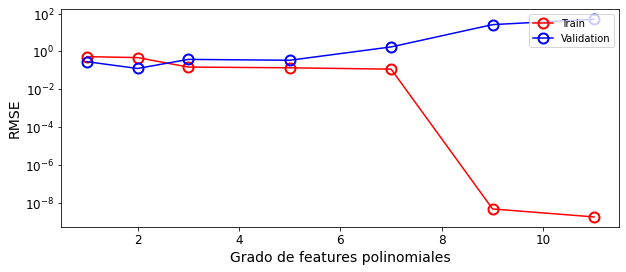

In [ ]:
# Veamos cómo evoluciona la métrica con el número de grados de libertad
plt.figure(figsize=(10,4))
plt.plot(degrees, rmse, 'o-r', mfc='None', ms=10, mew=2, label='Train')
plt.plot(degrees, rmse_val, 'o-b', mfc='None', ms=10, mew=2,label='Validation')
plt.xlabel('Grado de features polinomiales')
plt.ylabel('RMSE')
plt.yscale('log')
plt.legend(loc='upper right')
for i, d in enumerate(degrees):
    print(d, rmse[i], rmse_val[i])

Pero... puedo confiar en esta medida de validacion?

La verdad es que no, tengo pocos datos. Estoy calculando RMSE utilizando unicamente 2 mediciones. 

Si lo pensamos dos segundos, estamos desaprovechando datos. Para eso, y en particular cuando se tiene pocos datos y no toma demasiado tiempo la evaluacion del modelo, se utiliza la **validacion cruzada**.

## Validacion cruzada y K-Folding

La validacion cruzada por K-Folding consiste en divdir los datos en K particiones. Luego, se seleccionan K-1 de esas particiones y se entrena el modelo. Luego, se evalua en la particion restante. Esto se hace para cada una de las K combinaciones posibles y se hace estadistica sobre la evaluacion de validacion.

En particular, el mejor modelo es aquel cuya media es menor. La desviacion estandar da una idea de la incerteza de la metrica.

Cuando se tiene pocos datos, se pueden usar directamente $N$ particiones. Esto es lo que se denomina **Leave-One-Out Cross-Validation (LOO-CV)** 

Estas tecnicas estan incorporadas en `sklearn.model_selection.cross_val_score`.

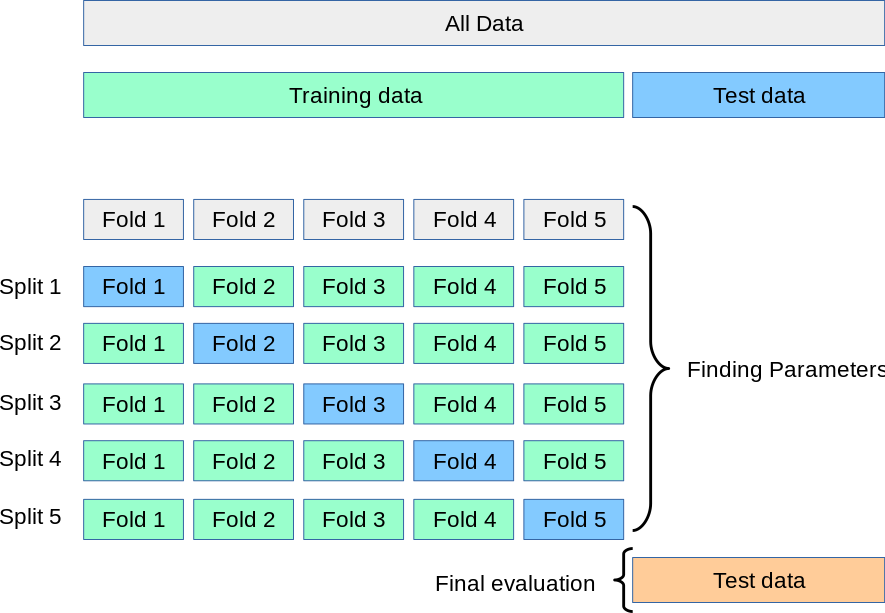

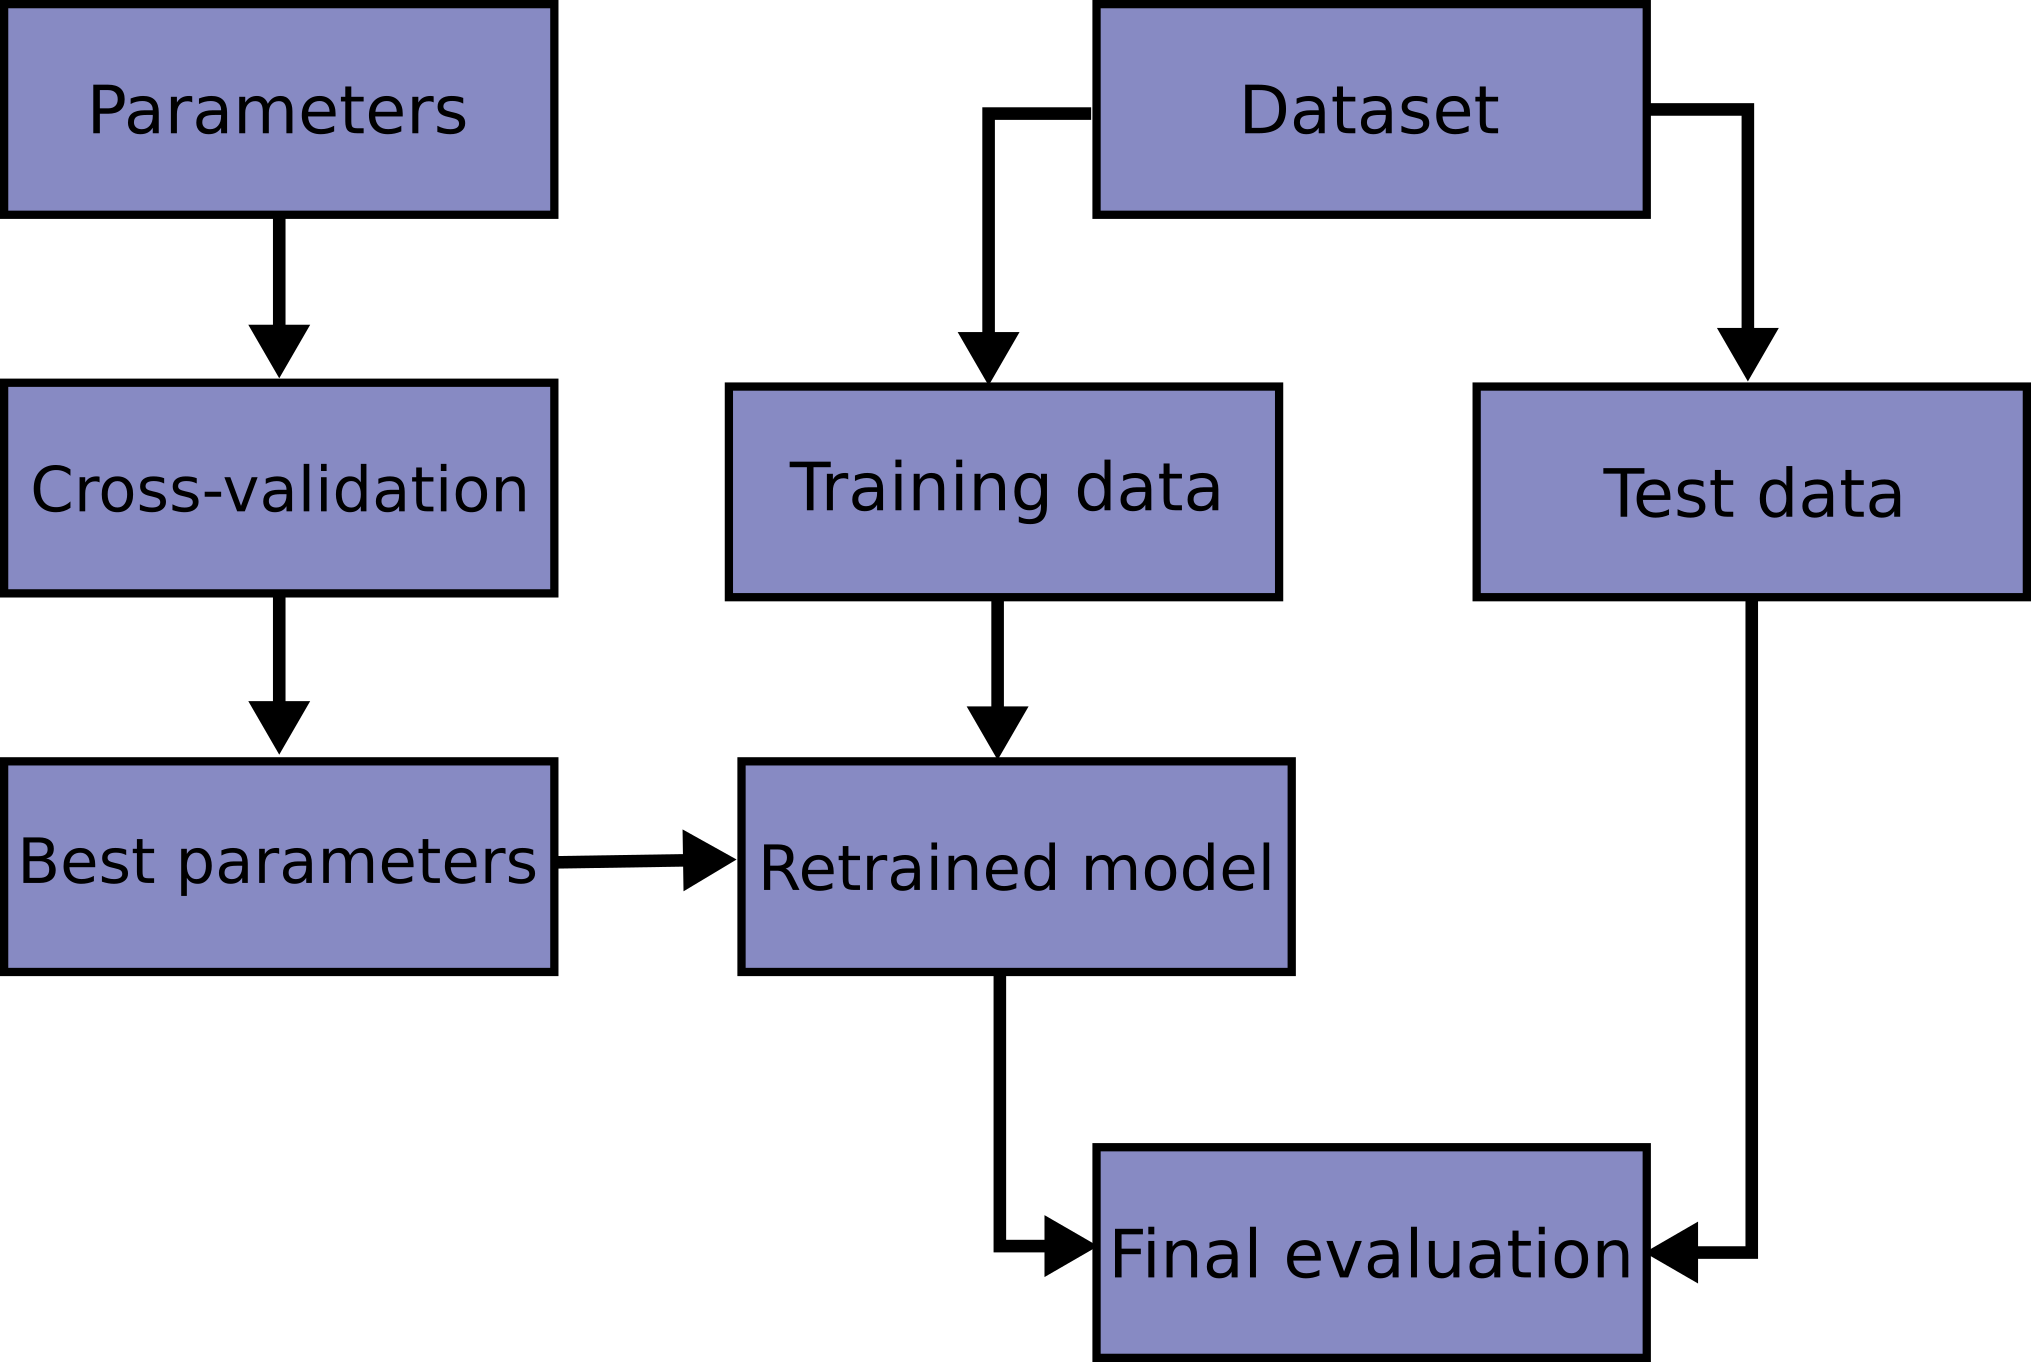

Hagamos un LOO-CV

In [ ]:
rmse_val=[]
for i in range(x_train.shape[0]):
  x_train_aux, t_train_aux = x_train[np.arange(x_train.shape[0])!=i], t_train[np.arange(t_train.shape[0])!=i]
  x_val_aux, t_val_aux =x_train[i], t_train[i]
  Phi_aux=np.hstack((x_train_aux*0.0+1.0,x_train_aux))
  pp1 = np.dot(Phi_aux.T, Phi_aux)
  yy = np.dot(Phi_aux.T, t_train_aux)
  wml_aux=np.linalg.solve(pp1, yy)
  Phi_val_aux=np.hstack((x_val_aux*0.0+1.0,x_val_aux))
  y_val_aux=np.dot(Phi_val_aux,wml_aux)
  rmse_val.append(np.sqrt(mse(t_val_aux, y_val_aux)))

In [ ]:
print("Media del RMSE:{}".format(np.mean(rmse_val)))
print("Desviacion estandar del RMSE:{}".format(np.sqrt(np.var(rmse_val,ddof=0))))

Media del RMSE:0.5734554674431827
Desviacion estandar del RMSE:0.37358392208081365


Comparemos con la implementacion de sklearn

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score?

In [ ]:
lr=LinearRegression()
loo_cv=cross_val_score(lr,x_train,t_train,cv=x_train.shape[0],scoring='neg_root_mean_squared_error')
errores = -loo_cv
print(errores.mean(), errores.std())

0.5734554674431827 0.37358392208081376


Ahora, apliquemos esto al problema de decidir el mejor grado del polinomio:

In [ ]:
def cv_multimodel(grados=range(10), cv=len(x_train), plot=True):
        
    rsmes = np.zeros(len(grados))
    std_rsmes = np.zeros(len(grados))
    
    for i, grado in enumerate(grados):
        # Crea un pipeline de sklearn con features de grado "grado"
        modelo = Pipeline([('features', PolynomialFeatures(degree=grado)),#x->[1,x,x^2,..,x^grado]
                           ('regression', LinearRegression(fit_intercept=False))
                          ])
        
        # Hace K-folding
        scores = cross_val_score(modelo, x_train, t_train, cv=cv, scoring='neg_root_mean_squared_error')
            
        # Como se usa un score, hay que pasarlo a Error cambiando de signo.
        rsmes[i] = (-scores).mean()
        std_rsmes[i] = (-scores).std()
        
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # Sin errores
        #ax.semilogy(grados, rsmes, 'o-', mfc='None')
        
        # Con errores
        ax.errorbar(grados, rsmes, std_rsmes, fmt='-o')
        ax.set_yscale('log')
        
        ax.set_xlabel('Grado')
        ax.set_ylabel('mean RMSE')
                
    return grados, rsmes, std_rsmes

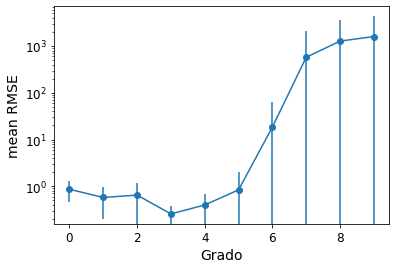

In [ ]:
grados, errors, errorst = cv_multimodel()

In [ ]:
print("El mejor grado es:{}".format(grados[np.argmin(errors)]))

El mejor grado es:3


Una vez decidimos el grado del polinomio, podemos ajustar **usando todos los datos de entrenamiento** y evaluar en el **conjunto de test**:

In [ ]:
# Definir el mejor modelo, elegido a partir de CV
modelo = Pipeline([('features', PolynomialFeatures(degree=3)),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])
# Ajustar con mi conjunto de training.
modelo.fit(x_train, t_train)

# Evaluar en el conjunto de test.
y_test = modelo.predict(x_test)
print('El error del mejor modelo en el conjunto de test es {:.2e}.'.format(np.sqrt(mse(t_test, y_test))))

El error del mejor modelo en el conjunto de test es 2.73e-01.


Veamos la version scikit-learn de lo que acabamos de hacer

In [ ]:
from sklearn.model_selection import GridSearchCV
GridSearchCV?

In [ ]:
modelo = Pipeline([('features', PolynomialFeatures()),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])
parameters={'features__degree':[1,2,3,4,5,6,10]}
grilla=GridSearchCV(modelo,parameters,refit=True)
grilla.fit(x_train,t_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('regression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'features__degree': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, r

In [ ]:
print(grilla.best_params_)


{'features__degree': 3}

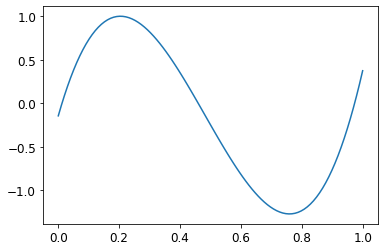

In [ ]:
elmejor=grilla.best_estimator_
plt.plot(xx,elmejor.predict(xx))

In [ ]:
for ni, i in enumerate([1,2,3,4,5,6,10]):
  print(i,-grilla.cv_results_['mean_test_score'][ni])

1 14.055902883331573
2 7.925145411302303
3 3.0408641516530013
4 4.433852938851838
5 276.06098843195457
6 732430.3075421526
10 67193222.17924997


# Weighted Least Squares

La clase pasada discutimos desviaciones de Cuadrados Minimos y como el algoritmo funciona a veces _a pesar_ de esas desviaciones. Sin embargo, hay tambien maneras de incorporar al algoritmo y resolver una version modificada.

En particular, si relajamos la hipotesis de homocedasticidad pero mantenemos mediciones independientes podemos aplicar el algoritmo de WLS.

Si cada medicion $t_{n}$ tiene desviacion estandar $\sigma_{n}$ **conocida**, entonces la funcion a minimizar sera:

$E_{D}(\vec{w})=\sum_{n=1}^{N}\frac{(t_{n}-y(\vec{x}_{n},\vec{w}))^{2}}{\sigma^{2}_{n}}$

Con un poco de ojo critico, podemos definir las nuevas variables $t'=\frac{t}{\sigma}$ e $y'=\frac{y}{\sigma}$. Entonces, el algoritmo es identico al caso homocedastico pero en un nuevo espacio.

$E_{D}(\vec{w})=\sum_{n=1}^{N}(t^{'}_{n}-y^{'}(\vec{x}_{n},\vec{w}))^{2}$

Veamos un ejemplo. Supongamos que ahora los mismos datos tienen un error $\sqrt{|t|+0.001}$.

In [ ]:
t_train_scaled=t_train/np.sqrt(np.abs(t_train)+0.001)
Phi=np.hstack((1/np.sqrt(np.abs(t_train)+0.001),x_train/np.sqrt(np.abs(t_train)+0.001)))

In [ ]:
# Ahora calculemos el producto de phi por su transpuesta y verifiquemos que la forma es la correcta
pp1 = np.dot(Phi.T, Phi)
# y el producto entre Phi y el vector t
yy = np.dot(Phi.T, t_train)
wml = np.linalg.solve(pp1, yy)
print(wml)

[[ 0.48407144]
 [-1.11746283]]


Para hacer predicciones, volvemos al espacio de $y$ y $t$.

Text(0.5, 1.0, 'Grado 1')

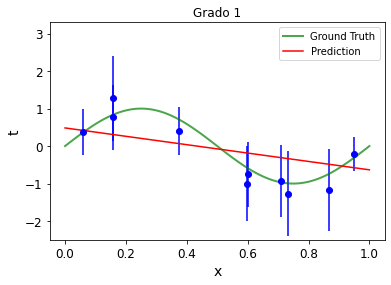

In [ ]:
Phi_preds=np.hstack((xx*0.0+1.0,xx))
preds_manual=np.dot(Phi_preds,wml)
# print(t_train.shape)
plt.errorbar(x_train[:,0], t_train[:,0], np.sqrt(np.abs(t_train)+0.001)[:,0], fmt='ob')#'ob', mfc='None', ms=10)
plt.plot(xx, np.sin(2*np.pi * xx),'g-', lw=2, alpha=0.7, label='Ground Truth')
plt.xlabel('x')
plt.ylabel('t')
plt.plot(xx, preds_manual, 'r-', label='Prediction')
plt.ylim(-2.5, 3.3)
plt.legend(loc=0)
plt.title('Grado {}'.format(1))

Estos tipos de fitteo van a buscar acomodar los puntos con menor error, ya que son los mas "seguros". 

`LinearRegression()` ofrece la opcion de poner un `sample_weight` a la hora de fittear.

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
import sklearn.preprocessing  as pp
from sklearn.linear_model import LinearRegression

# Creo el pipeline
pp_sine = Pipeline([('poly', pp.PolynomialFeatures()),
                     ('lr', LinearRegression(fit_intercept=False))])

# Inicializo listas
degrees = [1, 2, 3, 5, 7, 9, 11]
coeffs = []
rmse = []
rmse_test = []
preds = []
# Itero sobre los grados
for d in degrees:
    # Fijo el grado
    pp_sine.named_steps['poly'].degree = d
    
    # Fiteo (y registro los valores de los parámetros)
    error=np.append([0.00001],np.sqrt(np.abs(t_train)+0.001)[1:,0])
    pp_sine.fit(x_train, t_train,lr__sample_weight=list(map(lambda x: 1/x**2,error)))
    coeffs.append(pp_sine.named_steps['lr'].coef_)
    
    # Obtengo predicciones
    y_train = pp_sine.predict(x_train)
    y_test = pp_sine.predict(x_test)
    preds.append(pp_sine.predict(xx))

    # Calculo el RMSE    
    rmse.append(np.sqrt(mse(t_train, y_train)))
    rmse_test.append(np.sqrt(mse(t_test, y_test)))

1 0.683191717485791 0.5920749826360294
2 0.6843661291113621 0.5887952916497973
3 0.18480091390718992 0.2907098186204231
5 0.1636696731888563 0.2735278192947021
7 0.12634969777622748 5.55256221635301
9 2.3358532020354103e-08 2026.3103268517411
11 6.68825162482181e-09 1694.8055265411456


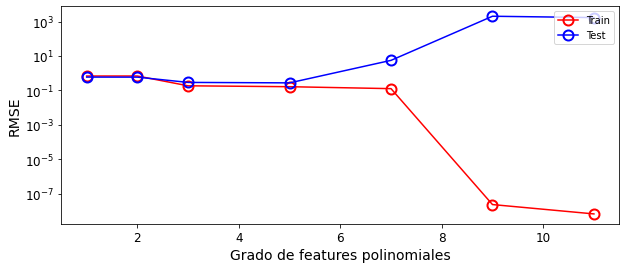

In [ ]:
# Veamos cómo evoluciona la métrica con el número de grados de libertad
plt.figure(figsize=(10,4))
plt.plot(degrees, rmse, 'o-r', mfc='None', ms=10, mew=2, label='Train')
plt.plot(degrees, rmse_test, 'o-b', mfc='None', ms=10, mew=2,label='Test')
plt.xlabel('Grado de features polinomiales')
plt.ylabel('RMSE')
plt.yscale('log')
plt.legend(loc='upper right')
for i, d in enumerate(degrees):
    print(d, rmse[i], rmse_test[i])

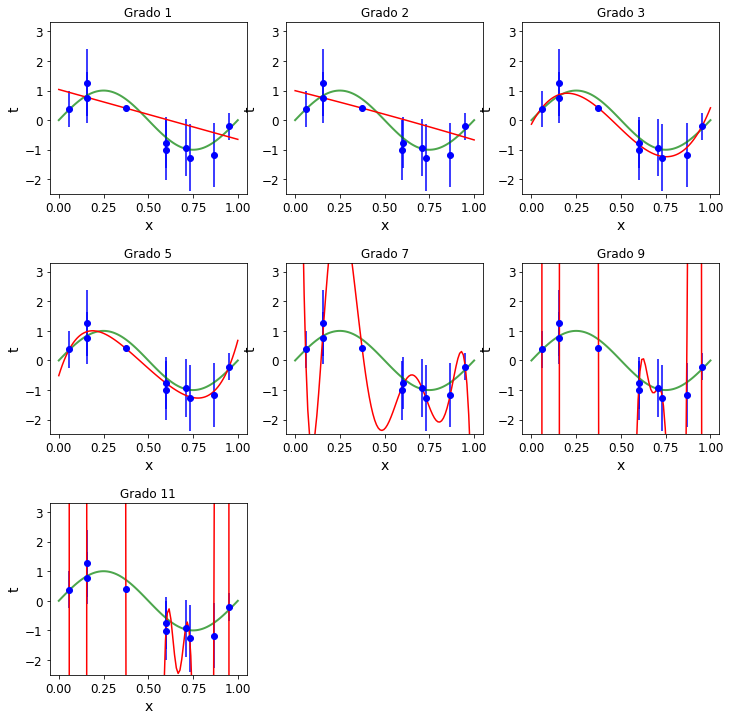

In [ ]:
ncols = 3
nrows = np.int(np.ceil(len(degrees)/ncols))

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

for i, d in enumerate(degrees):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.errorbar(x_train[:,0], t_train[:,0], np.append([0.00001],np.sqrt(np.abs(t_train)+0.001)[1:,0]), fmt='ob')#'ob', mfc='None', ms=10)
    ax.plot(xx, np.sin(2*np.pi * xx),'g-', lw=2, alpha=0.7, label='Ground Truth')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.plot(xx, preds[i], 'r-', label='Prediction')
    ax.set_ylim(-2.5, 3.3)
    ax.set_title('Grado {}'.format(d))